In [18]:
import scipy.io

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd

import numpy as np

from game import Game
from strategies import FastAttractorMemory, BaseStrategy, PerfectMemory
from memory import FastAttractor

import torch
from tqdm import tqdm

from fiftyone import ViewField as F

import scipy.io as sio

import math

In [3]:
n_trials = 20

steps = 10

size_range = [[3,3], [4,4], [5,5], [6,6], [7,7]]

# Functions

In [4]:
def save_mat(path, df):
    result = []

    for column in df.columns:
        entries = df[column].values
        column_tuple = (np.array([column]), entries.reshape(-1, 1))
        result.append(column_tuple)

    # Convert the result list to an array
    result_array = np.array(result)

    sio.savemat(path, {'b_data': result_array})

In [5]:
def play_strategy(strategy, game, max_steps=1500):
    win = False
    steps = 0
    while not win and steps < max_steps:
        strategy.pick()
        win = game.check_win()
        torch.cuda.empty_cache()
        steps+=1

In [6]:
def collect_data(n_trials, size_range, strategy, game):
    dfs = []
    tot_clicks = []
    for i, size in enumerate(size_range): 
        size_clicks = []
        for n in tqdm(range(n_trials), desc=f'Size: {size}'):
            game.set_size(size, 2)
            strategy.reset()
            play_strategy(strategy, game)
            df, nc = game.get_metrics()
            df['id'] = i*n_trials + n
            dfs.append(df)
            size_clicks.append(nc)
        tot_clicks.append(size_clicks)
    return pd.concat(dfs).reset_index(drop=True), tot_clicks

In [7]:
def add_reaction_times_confidence(activation_history, df, size):
    tiles_clicked = df['tile_clicked'].to_numpy()-1
    indices = np.tile(np.repeat([False, True, False], steps), len(tiles_clicked) // 2)
    history = activation_history[indices]
    neuron = np.repeat(tiles_clicked[1::2], steps)
    x = history[torch.arange(history.size(0)), neuron].view(-1, steps)
    max_v, _ = torch.max(x, dim=1, keepdim=True)
    min_v, _ = torch.min(x, dim=1, keepdim=True)
    means = torch.mean(history[:, :size], axis=1).numpy()
    df['reaction_time'] = np.repeat(np.argmax(torch.abs(x - min_v) >= torch.abs(0.9 * (max_v - min_v)), axis=1), 2)
    df['confidence'] = np.repeat(torch.abs(max_v.flatten() - means[steps-1::steps]) / torch.max(torch.abs(max_v.flatten() - means[steps-1::steps])), 2)
    return df

In [8]:
def extract_energy(energy_history, df):
    tiles_clicked = df['tile_clicked'].to_numpy()-1
    indices = np.tile(np.repeat([True, False, False], steps), len(tiles_clicked) // 2)
    energy = energy_history[indices].view(-1, steps)
    max_v, _ = torch.max(energy, dim=1, keepdim=True)
    min_v, _ = torch.min(energy, dim=1, keepdim=True)
    df['max_energy'] = np.repeat((max_v.flatten() - min_v.flatten()) / -min_v.flatten(), 2)
    return df

In [9]:
def collect_data_attractor(n_trials, size_range, game, lr, rr):
    dfs = []
    tot_clicks = []
    for i, size in enumerate(size_range): 
        size_clicks = []
        for n in tqdm(range(n_trials), desc=f'Size: {size}'):
            game.set_size(size, 2)
            dim = np.prod(size) + len(np.unique(game.get_grid_labels()))
            memory = FastAttractor(dim, lr, rr)
            strategy = FastAttractorMemory(game, memory, steps=steps)
            play_strategy(strategy, game)
            history = memory.get_activation_history()
            df, nc = game.get_metrics()
            df = add_reaction_times_confidence(history, df, np.prod(size))
            energy_history = memory.get_energy_history()
            df = extract_energy(energy_history, df)
            df['id'] = i*n_trials + n
            dfs.append(df)
            size_clicks.append(nc)
        tot_clicks.append(size_clicks)
    return pd.concat(dfs).reset_index(drop=True), tot_clicks

In [10]:
def get_second_click_df(df):
    o_df = pd.DataFrame()
    o_df['id'] = df['id'].to_numpy()[1::2]
    o_df['match'] = df['match'].to_numpy()[1::2]
    o_df['random_match'] = df['random_match'].to_numpy()[1::2]
    o_df['board_size'] = df['board_size'].to_numpy()[1::2]
    o_df['tile_clicked'] = df['tile_clicked'].to_numpy()[1::2]
    o_df['nslc'] = df['nslc'].to_numpy()[1::2]
    o_df['nslc_first'] = df['nslc'].to_numpy()[0::2] # nslc referring to the first click of the trial
    o_df['nsp'] = df['nsp'].to_numpy()[1::2]
    o_df['correct_tile'] = df['correct_tile'].to_numpy()[0::2]
    o_df['reaction_time'] = df['reaction_time'].to_numpy()[1::2]
    o_df['confidence'] = df['confidence'].to_numpy()[1::2]
    o_df['max_energy'] = df['max_energy'].to_numpy()[1::2]
    return o_df

In [11]:
def build_nc_df(nc, strategy):
    data = []
    for i, size in enumerate(size_range):
        for j in range(n_trials):
            data.append({'size': str(size[0]), 'nc': math.log10(nc[i][j]/np.prod(size))})
    data = pd.DataFrame(data)
    data['strategy'] = strategy
    return data

In [12]:
game = Game()
# Use the following to have actual images from "coco-2017" in the grid
# game = Game(
#             dataset_name='coco-2017', 
#             split='validation', 
#             field="ground_truth", 
#             ds_filter=F("supercategory").is_in(('person', 'animal', 'food', 'vehicle', 'indoor')),
#             dataset_dir ="/home/ravi/datasets/coco-2017",
#         )

# Benchmarks

In [13]:
bs = BaseStrategy(game)
bs_df, bs_nc = collect_data(n_trials, size_range, bs, game)
bs_nc_df = build_nc_df(bs_nc, 'Random Memory')
bs_df['strategy'] = 'Random memory'

Size: [7, 7]: 100%|██████████| 20/20 [00:00<00:00, 42.95it/s]


In [14]:
pm = PerfectMemory(game)
pm_df, pm_nc = collect_data(n_trials, size_range, pm, game)
pm_nc_df = build_nc_df(pm_nc, 'Perfect Memory')
pm_df['strategy'] = 'Perfect memory'

Size: [7, 7]: 100%|██████████| 20/20 [00:00<00:00, 398.59it/s]


# Attractor

In [15]:
att_df_double, att_nc = collect_data_attractor(n_trials, size_range, game, .6, .9)
att_df = get_second_click_df(att_df_double) # Only get the second click for each trial
save_mat('model_metrics.mat', att_df)
att_nc_df = build_nc_df(att_nc, 'Attractor Memory')
att_df['strategy'] = 'Attractor Memory'

Size: [7, 7]: 100%|██████████| 20/20 [00:05<00:00,  3.97it/s]


# Behavioral metrics

In [16]:
df = att_df
df['Trial'] = 'Mismatch'
df.loc[df['match'] == 1, 'Trial'] = 'Match'
df['board_size'] = df['board_size'].apply(np.sqrt)

## Reaction Time

<Figure size 800x1600 with 0 Axes>

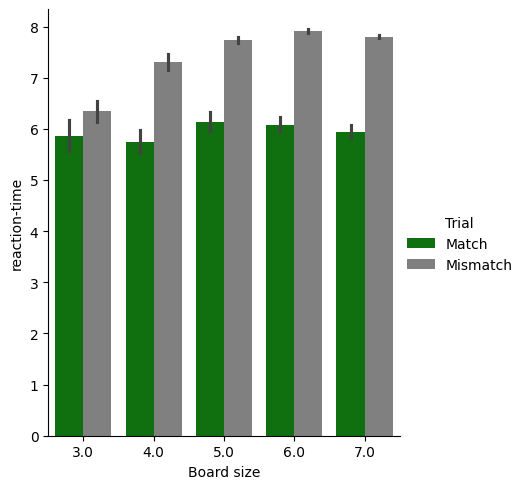

In [17]:
plt.figure(figsize=(8, 16))
palette = ['green', 'grey'] 
# Draw a nested barplot by species and sex
ax = sns.catplot(x="board_size", y="reaction_time", hue='Trial', data=df, aspect=0.85, kind='bar', errorbar='se', palette=palette, hue_order=['Match', 'Mismatch'])
ax.set(xlabel="Board size", ylabel="reaction-time")
plt.show()

# Confidence

<Figure size 800x1600 with 0 Axes>

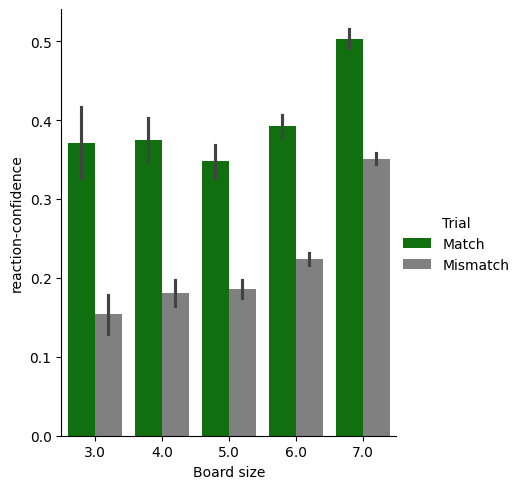

In [18]:
plt.figure(figsize=(8, 16))
palette = ['green', 'grey']
# Draw a nested barplot by species and sex
ax = sns.catplot(x="board_size", y="confidence", hue='Trial', data=df, aspect=0.85, kind='bar', errorbar='se', palette=palette, hue_order=['Match', 'Mismatch'])
ax.set(xlabel="Board size", ylabel="reaction-confidence")
plt.show()

# Surprise

/tmp/ipykernel_756480/3925047851.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nslc_first['Data'] = 'First-click'
/tmp/ipykernel_756480/3925047851.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nslc_old['Data'] = 'nslc>1'
/tmp/ipykernel_756480/3925047851.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<Figure size 1600x1600 with 0 Axes>

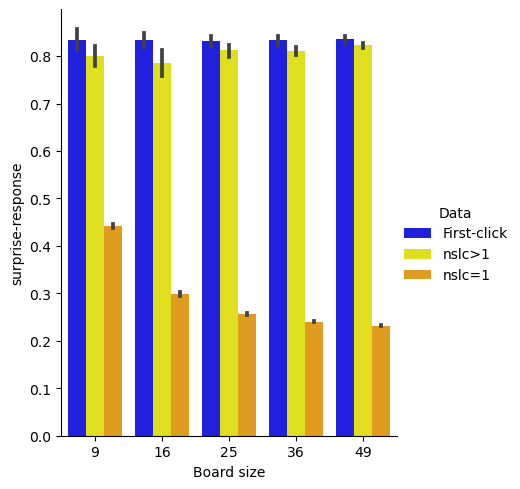

In [ ]:
n_df = pd.DataFrame()
n_df['nslc'] = att_df_double['nslc'].to_numpy()[0::2]
n_df['max_energy'] = att_df_double['max_energy'].to_numpy()[0::2]
n_df['board_size'] = att_df_double['board_size'].to_numpy()[0::2]

nslc_first = n_df[n_df['nslc'] <= 0]
nslc_first['Data'] = 'First-click'

nslc_old = n_df[n_df['nslc'] > 1]
nslc_old['Data'] = 'nslc>1'

nslc_recent = n_df[n_df['nslc'] == 1]
nslc_recent['Data'] = 'nslc=1'

nslc_df = pd.concat([nslc_first, nslc_old, nslc_recent])

palette = ['blue', 'yellow', 'orange']
plt.figure(figsize=(16, 16))
ax = sns.catplot(x="board_size", y="max_energy", hue='Data', data=nslc_df, aspect=0.85, kind='bar', palette=palette)
ax.set(xlabel="Board size", ylabel="surprise-response")
plt.show()

## nsp

<Figure size 800x1600 with 0 Axes>

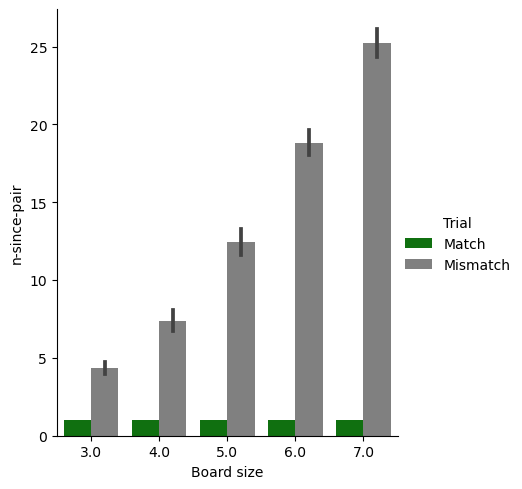

In [ ]:
plt.figure(figsize=(8, 16))
palette = ['green', 'grey']
# Draw a nested barplot by species and sex
ax = sns.catplot(x="board_size", y="nsp", hue='Trial', data=df[df['nsp'] > 0], aspect=0.85, errorbar='se', kind='bar', palette=palette, hue_order=['Match', 'Mismatch'])
ax.set(xlabel="Board size", ylabel="n-since-pair")
plt.show()

## NSLC

<Figure size 800x1600 with 0 Axes>

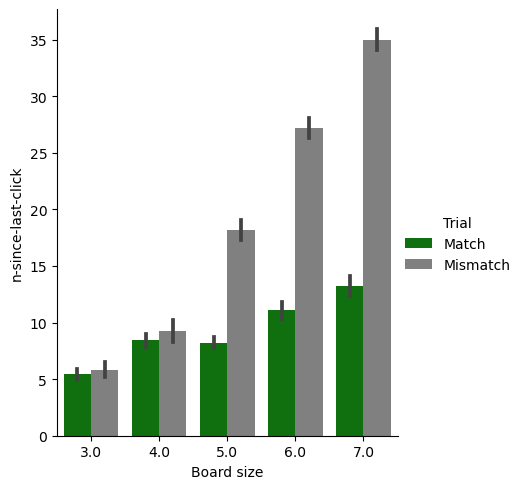

In [ ]:
plt.figure(figsize=(8, 16))
palette = ['green', 'grey']
# Draw a nested barplot by species and sex
ax = sns.catplot(x="board_size", y="nslc", hue='Trial', data=df[df['nslc'] > 0], aspect=0.85, errorbar='se', kind='bar', palette=palette, hue_order=['Match', 'Mismatch'])
ax.set(xlabel="Board size", ylabel="n-since-last-click")
plt.show()

## Tot clicks

<Figure size 800x1600 with 0 Axes>

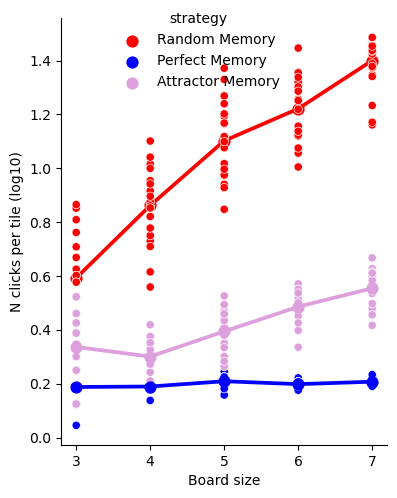

In [ ]:
data = pd.concat([bs_nc_df, pm_nc_df, att_nc_df])
plt.figure(figsize=(8, 16))
palette = ['red', 'blue', 'plum']
ax2 = sns.catplot(x="size", y='nc', hue="strategy", data=data, aspect=0.85, errorbar=None, kind='point', palette=palette)
ax = sns.scatterplot(x="size", y='nc', hue="strategy", data=data, legend=False, palette=palette)
ax.set_xlabel("Board size")
ax.set_ylabel("N clicks per tile (log10)")
sns.move_legend(ax2, "upper center")